# 数据导入与预处理

## 模块导入

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import gc
gc.enable()
import warnings
warnings.filterwarnings("ignore")

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.set_option('max_colwidth', 200)

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

## 数据导入

In [2]:
train = pd.read_csv('train.csv').sample(frac=1)
test = pd.read_csv('test.csv')

In [3]:
# train.head(5)

In [4]:
# test.head(5)

## Id特征处理

In [5]:
# 处理前数据形状
print(train.shape)
print(test.shape)

(59288, 26)
(14823, 25)


In [6]:
train_Id = train['数据ID']
test_Id = test['数据ID']
train.drop('数据ID', axis=1, inplace=True)
test.drop('数据ID', axis=1, inplace=True)

In [7]:
# 处理后数据形状
print(train.shape)
print(test.shape)

(59288, 25)
(14823, 24)


## 异常值处理

In [8]:
# 处理前数据分布
# fig, ax = plt.subplots()
# ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
# plt.xlabel('GrLivArea', fontsize=13)
# plt.ylabel('SalePrice', fontsize=13)
# plt.show()

In [9]:
# 删除右下角两个异常值
# train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [10]:
# 处理后数据分布
# fig, ax = plt.subplots()
# ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
# plt.xlabel('GrLivArea', fontsize=13)
# plt.ylabel('SalePrice', fontsize=13)
# plt.show()

## SalePrice特征处理


 mu=68.97 and sigma=10.35 



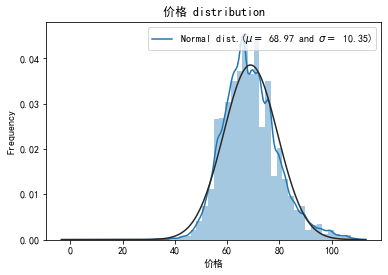

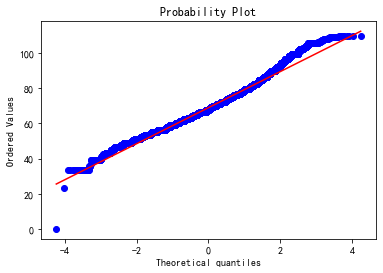

In [11]:
# 处理前数据分布
sns.distplot(train['价格'], fit=norm)

(mu, sigma) = norm.fit(train['价格'])
print('\n mu={:.2f} and sigma={:.2f} \n'.format(mu, sigma))

plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('价格 distribution')

fig = plt.figure()
stats.probplot(train['价格'], plot=plt)
plt.show()

In [12]:
# 数据偏度大，用log1p函数转化，使其更加服从高斯分布。
# 最后需要将预测出的平滑数据进行还原，而还原过程就是log1p的逆运算expm1
# train['价格'] = np.log1p(train['价格'])

In [13]:
# 处理后数据分布
# sns.distplot(train['价格'], fit=norm)

# (mu, sigma) = norm.fit(train['价格'])
# print('\n mu={:.2f} and sigma={:.2f} \n'.format(mu, sigma))

# plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
# plt.ylabel('Frequency')
# plt.title('价格 distribution')

# fig = plt.figure()
# stats.probplot(train['价格'], plot=plt)
# plt.show()

# 特征工程

## 数据集连接

In [14]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.价格.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['价格'], axis=1, inplace=True)
print('all_data size is {}'.format(all_data.shape))

all_data size is (74111, 24)


## 缺失数据分析

In [15]:
all_data.isnull().head()

,容纳人数,便利设施,洗手间数量,床的数量,床的类型,卧室数量,取消条款,所在城市,清洁费,首次评论日期,房主是否有个人资料图片,房主身份是否验证,房主回复率,何时成为房主,是否支持随即预订,最近评论日期,维度,经度,民宿周边,评论个数,房产类型,民宿评分,房型,邮编
0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [16]:
all_data.isnull().sum().head(10)

容纳人数          0
便利设施          0
洗手间数量       200
床的数量        131
床的类型          0
卧室数量         91
取消条款          0
所在城市          0
清洁费           0
首次评论日期    15864
dtype: int64

In [17]:
all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head(20)

,Missing Ratio
房主回复率,24.691341
民宿评分,22.563452
首次评论日期,21.405729
最近评论日期,21.355804
民宿周边,9.272578
邮编,1.303450
洗手间数量,0.269865
何时成为房主,0.253674
房主身份是否验证,0.253674
房主是否有个人资料图片,0.253674


Text(0.5, 1.0, 'Percent missing data by feature')

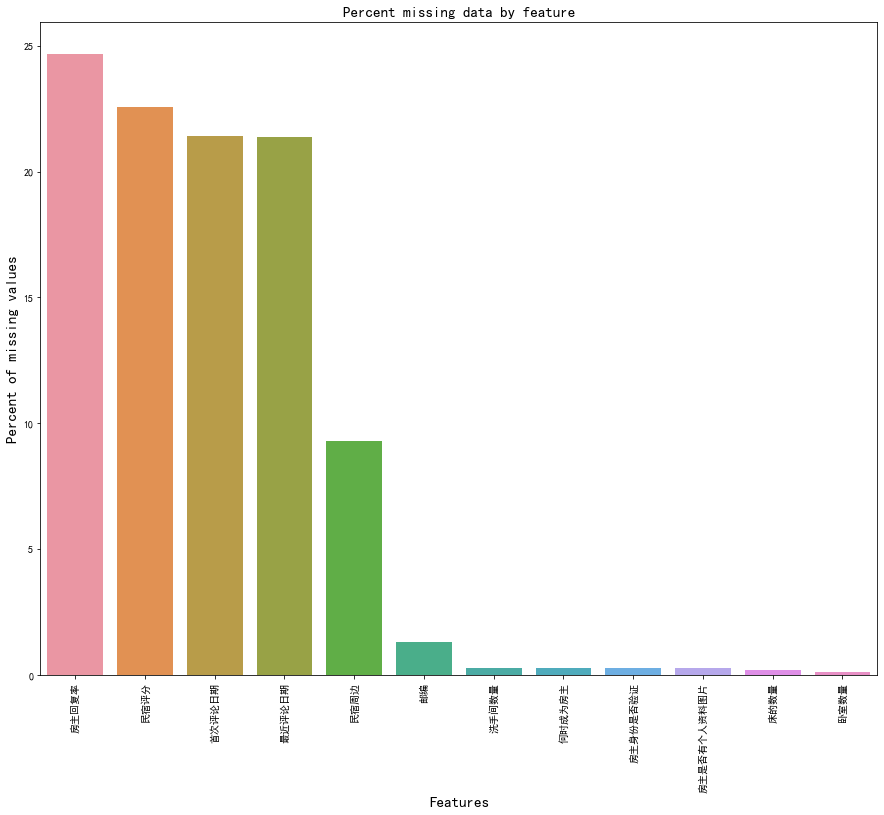

In [18]:
# 含有缺失值的特征的缺失率
f, axis = plt.subplots(figsize=(15,12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

## 数据相关性

<AxesSubplot:>

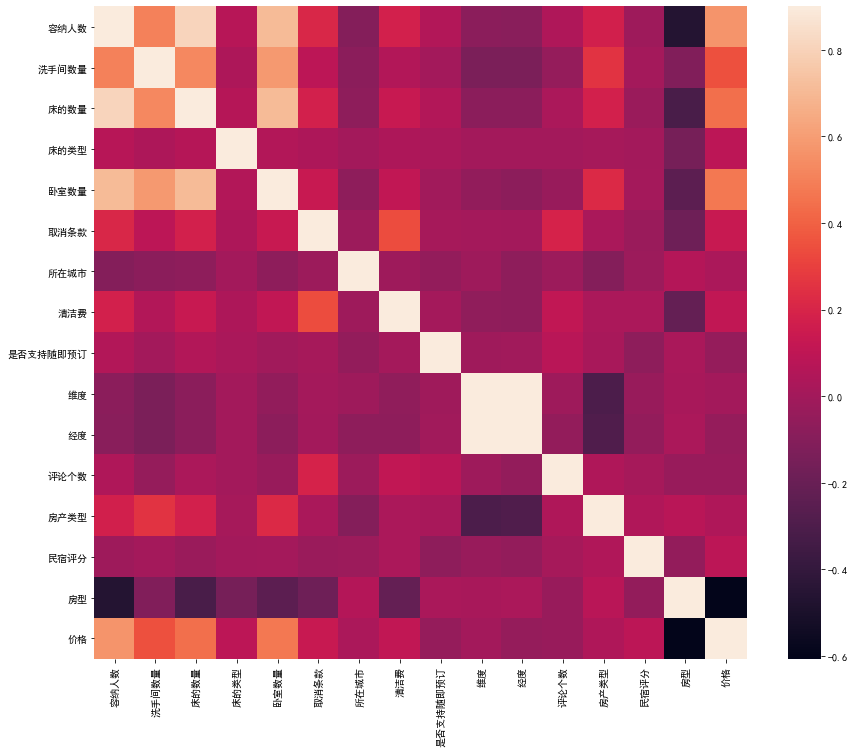

In [19]:
# 全部数值特征
corrmat = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corrmat, vmax=0.9, square=True)

<AxesSubplot:>

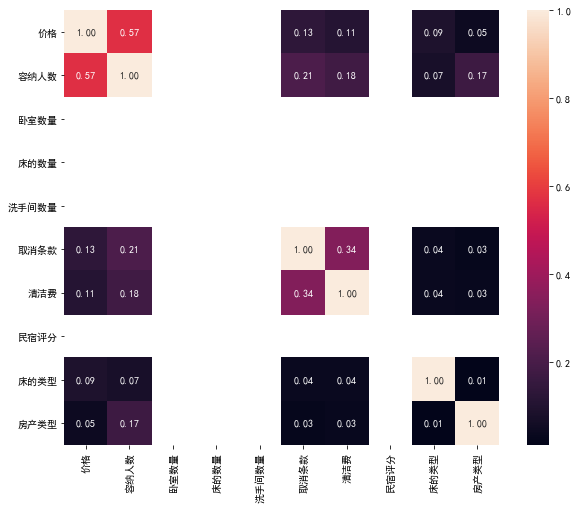

In [20]:
# 相关性最大的10个特征
corrmat = train.corr()
plt.subplots(figsize=(10,8))
k = 10
cols = corrmat.nlargest(k, '价格')['价格'].index
cm = np.corrcoef(train[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

## 缺失值填充

In [21]:
all_data.head()

,容纳人数,便利设施,洗手间数量,床的数量,床的类型,卧室数量,取消条款,所在城市,清洁费,首次评论日期,房主是否有个人资料图片,房主身份是否验证,房主回复率,何时成为房主,是否支持随即预订,最近评论日期,维度,经度,民宿周边,评论个数,房产类型,民宿评分,房型,邮编
0,2,"{TV,Internet,""Wireless Internet"",""Air conditioning"",Kitchen,Doorman,Elevator,Heating,Washer,Dryer,""Smoke detector"",""Fire extinguisher"",Essentials,Shampoo}",1.0,1.0,4,0.0,0,4,0,2015-07-01,t,t,NaN,2015-02-10,0,2015-08-25,40.811860,-73.940186,Harlem,2,0,90.0,0,10037
1,2,"{TV,Internet,""Wireless Internet"",""Air conditioning"",Kitchen,""Buzzer/wireless intercom"",Heating,""Family/kid friendly"",""Smoke detector"",""Carbon monoxide detector"",""First aid kit"",""Safety card"",Essen...",1.0,1.0,4,1.0,1,4,1,2016-11-18,t,f,90%,2009-12-02,0,2017-09-19,40.784396,-73.948557,Upper East Side,21,0,98.0,1,10128
2,1,"{TV,""Wireless Internet"",Kitchen,Washer,Dryer,""Smoke detector"",""Carbon monoxide detector"",""Lock on bedroom door"",Hangers,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_49"",""tr...",1.0,1.0,4,1.0,2,0,1,2016-06-19,t,t,96%,2015-12-29,0,2016-06-19,42.283933,-71.068835,Dorchester,1,0,20.0,1,02124
3,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Free parking on premises"",Heating,""Family/kid friendly""}",1.0,1.0,4,1.0,1,3,1,2012-04-12,t,t,100%,2012-04-02,0,2017-04-16,34.077372,-118.266653,Echo Park,317,5,98.0,0,90026
4,5,"{TV,""Cable TV"",Internet,""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Washer,Dryer,""First aid kit"",Essentials,Shampoo,""Hair dryer"",Iron,""Laptop friendly workspace"",""...",1.0,3.0,4,1.0,1,3,1,2014-05-26,t,t,100%,2013-03-22,0,2017-04-17,34.112705,-118.255947,Atwater Village,91,0,93.0,0,90039


In [22]:
# 根据各特征的现实含义，填充合适的值
feature1 = ['床的类型','邮编','房主回复率','首次评论日期','最近评论日期','何时成为房主','民宿周边','房主身份是否验证','房主是否有个人资料图片']
for i in feature1:
    all_data[i] = all_data[i].fillna('None')
    
feature2 = ['评论个数','洗手间数量']
for i in feature2:
    all_data[i] = all_data[i].fillna(0)

## 数值型
feature3 = ['民宿评分', '卧室数量', '取消条款', '床的数量','经度' ,'维度']
for i in feature3:
    all_data[i] = all_data[i].fillna(all_data[i].mode()[0])


    
# all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# all_data = all_data.drop(['Utilities'], axis=1)
# all_data['Functional'] = all_data['Functional'].fillna('Typ')

In [23]:
# 填充完成后，查看是否还有缺失值
all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head()

,Missing Ratio


In [24]:
all_data.head()

,容纳人数,便利设施,洗手间数量,床的数量,床的类型,卧室数量,取消条款,所在城市,清洁费,首次评论日期,房主是否有个人资料图片,房主身份是否验证,房主回复率,何时成为房主,是否支持随即预订,最近评论日期,维度,经度,民宿周边,评论个数,房产类型,民宿评分,房型,邮编
0,2,"{TV,Internet,""Wireless Internet"",""Air conditioning"",Kitchen,Doorman,Elevator,Heating,Washer,Dryer,""Smoke detector"",""Fire extinguisher"",Essentials,Shampoo}",1.0,1.0,4,0.0,0,4,0,2015-07-01,t,t,None,2015-02-10,0,2015-08-25,40.811860,-73.940186,Harlem,2,0,90.0,0,10037
1,2,"{TV,Internet,""Wireless Internet"",""Air conditioning"",Kitchen,""Buzzer/wireless intercom"",Heating,""Family/kid friendly"",""Smoke detector"",""Carbon monoxide detector"",""First aid kit"",""Safety card"",Essen...",1.0,1.0,4,1.0,1,4,1,2016-11-18,t,f,90%,2009-12-02,0,2017-09-19,40.784396,-73.948557,Upper East Side,21,0,98.0,1,10128
2,1,"{TV,""Wireless Internet"",Kitchen,Washer,Dryer,""Smoke detector"",""Carbon monoxide detector"",""Lock on bedroom door"",Hangers,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_49"",""tr...",1.0,1.0,4,1.0,2,0,1,2016-06-19,t,t,96%,2015-12-29,0,2016-06-19,42.283933,-71.068835,Dorchester,1,0,20.0,1,02124
3,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Free parking on premises"",Heating,""Family/kid friendly""}",1.0,1.0,4,1.0,1,3,1,2012-04-12,t,t,100%,2012-04-02,0,2017-04-16,34.077372,-118.266653,Echo Park,317,5,98.0,0,90026
4,5,"{TV,""Cable TV"",Internet,""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Washer,Dryer,""First aid kit"",Essentials,Shampoo,""Hair dryer"",Iron,""Laptop friendly workspace"",""...",1.0,3.0,4,1.0,1,3,1,2014-05-26,t,t,100%,2013-03-22,0,2017-04-17,34.112705,-118.255947,Atwater Village,91,0,93.0,0,90039


## 标签编码

In [25]:
# 查看待编码特征情况
cols = ['便利设施','床的类型','邮编','房主回复率','首次评论日期','最近评论日期','何时成为房主','民宿周边','房主身份是否验证','房主是否有个人资料图片']

all_data[cols].head()

,便利设施,床的类型,邮编,房主回复率,首次评论日期,最近评论日期,何时成为房主,民宿周边,房主身份是否验证,房主是否有个人资料图片
0,"{TV,Internet,""Wireless Internet"",""Air conditioning"",Kitchen,Doorman,Elevator,Heating,Washer,Dryer,""Smoke detector"",""Fire extinguisher"",Essentials,Shampoo}",4,10037,None,2015-07-01,2015-08-25,2015-02-10,Harlem,t,t
1,"{TV,Internet,""Wireless Internet"",""Air conditioning"",Kitchen,""Buzzer/wireless intercom"",Heating,""Family/kid friendly"",""Smoke detector"",""Carbon monoxide detector"",""First aid kit"",""Safety card"",Essen...",4,10128,90%,2016-11-18,2017-09-19,2009-12-02,Upper East Side,f,t
2,"{TV,""Wireless Internet"",Kitchen,Washer,Dryer,""Smoke detector"",""Carbon monoxide detector"",""Lock on bedroom door"",Hangers,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_49"",""tr...",4,02124,96%,2016-06-19,2016-06-19,2015-12-29,Dorchester,t,t
3,"{TV,Internet,""Wireless Internet"",Kitchen,""Free parking on premises"",Heating,""Family/kid friendly""}",4,90026,100%,2012-04-12,2017-04-16,2012-04-02,Echo Park,t,t
4,"{TV,""Cable TV"",Internet,""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Washer,Dryer,""First aid kit"",Essentials,Shampoo,""Hair dryer"",Iron,""Laptop friendly workspace"",""...",4,90039,100%,2014-05-26,2017-04-17,2013-03-22,Atwater Village,t,t


In [26]:
# 将数值类型转化为字符串类型
feature = ['床的类型', '房产类型', '房型', '所在城市','是否支持随即预订']
for i in feature:
    all_data[i] = all_data[i].astype(str)

In [27]:
# 标签编码对不连续的数字或者文本进行编号,转换成连续的数值型变量
for c in cols:
    le = LabelEncoder()
    le.fit(list(all_data[c].values))
    all_data[c] = le.transform(list(all_data[c].values))

In [28]:
# 编码后特征情况
all_data[cols].head()



,便利设施,床的类型,邮编,房主回复率,首次评论日期,最近评论日期,何时成为房主,民宿周边,房主身份是否验证,房主是否有个人资料图片
0,60555,4,99,80,1726,599,2120,247,2,2
1,54527,4,114,70,2232,1354,253,556,1,2
2,52634,4,14,76,2080,897,2442,147,2,2
3,65161,4,453,2,575,1198,1076,173,2,2
4,34596,4,468,2,1326,1199,1430,24,2,2


In [29]:
pd.set_option('max_columns', 80)
all_data.head()

,容纳人数,便利设施,洗手间数量,床的数量,床的类型,卧室数量,取消条款,所在城市,清洁费,首次评论日期,房主是否有个人资料图片,房主身份是否验证,房主回复率,何时成为房主,是否支持随即预订,最近评论日期,维度,经度,民宿周边,评论个数,房产类型,民宿评分,房型,邮编
0,2,60555,1.0,1.0,4,0.0,0,4,0,1726,2,2,80,2120,0,599,40.811860,-73.940186,247,2,0,90.0,0,99
1,2,54527,1.0,1.0,4,1.0,1,4,1,2232,2,1,70,253,0,1354,40.784396,-73.948557,556,21,0,98.0,1,114
2,1,52634,1.0,1.0,4,1.0,2,0,1,2080,2,2,76,2442,0,897,42.283933,-71.068835,147,1,0,20.0,1,14
3,2,65161,1.0,1.0,4,1.0,1,3,1,575,2,2,2,1076,0,1198,34.077372,-118.266653,173,317,5,98.0,0,453
4,5,34596,1.0,3.0,4,1.0,1,3,1,1326,2,2,2,1430,0,1199,34.112705,-118.255947,24,91,0,93.0,0,468


## 增加特征

In [30]:
# all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

## 倾斜特征

In [31]:
all_data.dtypes.head(10)

容纳人数        int64
便利设施        int64
洗手间数量     float64
床的数量      float64
床的类型        int64
卧室数量      float64
取消条款        int64
所在城市       object
清洁费         int64
首次评论日期      int64
dtype: object

In [32]:
all_data.dtypes[all_data.dtypes != 'object'].index

Index(['容纳人数', '便利设施', '洗手间数量', '床的数量', '床的类型', '卧室数量', '取消条款', '清洁费',
       '首次评论日期', '房主是否有个人资料图片', '房主身份是否验证', '房主回复率', '何时成为房主', '最近评论日期', '维度',
       '经度', '民宿周边', '评论个数', '民宿评分', '邮编'],
      dtype='object')

In [33]:
# 计算特征偏度
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew':skewed_feats})
skewness

,Skew
评论个数,3.702760
洗手间数量,3.621649
床的数量,3.360728
容纳人数,2.231515
卧室数量,1.991787
房主回复率,0.513749
邮编,0.292904
便利设施,0.003907
民宿周边,-0.050597
取消条款,-0.240908


In [34]:
all_data.isnull().sum()

容纳人数           0
便利设施           0
洗手间数量          0
床的数量           0
床的类型           0
卧室数量           0
取消条款           0
所在城市           0
清洁费            0
首次评论日期         0
房主是否有个人资料图片    0
房主身份是否验证       0
房主回复率          0
何时成为房主         0
是否支持随即预订       0
最近评论日期         0
维度             0
经度             0
民宿周边           0
评论个数           0
房产类型           0
民宿评分           0
房型             0
邮编             0
dtype: int64

In [35]:
# 对偏态分布的数据进行标准化处理，使其更加服从正态分布
skewness = skewness[abs(skewness.Skew) > 0.75]
print('There are {} skewed numerical features to Box Cox transform'.format(skewness.shape[0]))
# print(skewed_features)
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    print(feat)
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
# all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 12 skewed numerical features to Box Cox transform
评论个数
洗手间数量
床的数量
容纳人数
卧室数量
房主身份是否验证
清洁费
首次评论日期
最近评论日期
民宿评分
床的类型
房主是否有个人资料图片


In [36]:
all_data.isnull().sum()

容纳人数           0
便利设施           0
洗手间数量          0
床的数量           0
床的类型           0
卧室数量           0
取消条款           0
所在城市           0
清洁费            0
首次评论日期         0
房主是否有个人资料图片    0
房主身份是否验证       0
房主回复率          0
何时成为房主         0
是否支持随即预订       0
最近评论日期         0
维度             0
经度             0
民宿周边           0
评论个数           0
房产类型           0
民宿评分           0
房型             0
邮编             0
dtype: int64

In [37]:
all_data.head()


,容纳人数,便利设施,洗手间数量,床的数量,床的类型,卧室数量,取消条款,所在城市,清洁费,首次评论日期,房主是否有个人资料图片,房主身份是否验证,房主回复率,何时成为房主,是否支持随即预订,最近评论日期,维度,经度,民宿周边,评论个数,房产类型,民宿评分,房型,邮编
0,1.194318,60555,0.730463,0.730463,1.820334,0.000000,0,4,0.000000,13.727342,1.194318,1.194318,80,2120,0,10.736626,40.811860,-73.940186,247,1.194318,0,6.448232,0,99
1,1.194318,54527,0.730463,0.730463,1.820334,0.730463,1,4,0.730463,14.528754,1.194318,0.730463,70,253,0,12.998591,40.784396,-73.948557,556,3.932510,0,6.615044,1,114
2,0.730463,52634,0.730463,0.730463,1.820334,0.730463,2,0,0.730463,14.305802,1.194318,1.194318,76,2442,0,11.821770,42.283933,-71.068835,147,0.730463,0,3.858807,1,14
3,1.194318,65161,0.730463,0.730463,1.820334,0.730463,1,3,0.730463,10.630386,1.194318,1.194318,2,1076,0,12.641081,34.077372,-118.266653,173,9.155750,5,6.615044,0,453
4,2.055642,34596,0.730463,1.540963,1.820334,0.730463,1,3,0.730463,12.937093,1.194318,1.194318,2,1430,0,12.643496,34.112705,-118.255947,24,6.469750,0,6.512196,0,468


## 独热编码

In [38]:
# 独热编码用来解决类别型数据的离散值问题
all_data = pd.get_dummies(all_data)
all_data.head()

,容纳人数,便利设施,洗手间数量,床的数量,床的类型,卧室数量,取消条款,清洁费,首次评论日期,房主是否有个人资料图片,房主身份是否验证,房主回复率,何时成为房主,最近评论日期,维度,经度,民宿周边,评论个数,民宿评分,邮编,所在城市_0,所在城市_1,所在城市_2,所在城市_3,所在城市_4,所在城市_5,是否支持随即预订_0,是否支持随即预订_1,房产类型_0,房产类型_1,房产类型_10,房产类型_11,房产类型_12,房产类型_13,房产类型_14,房产类型_15,房产类型_16,房产类型_17,房产类型_18,房产类型_19,房产类型_2,房产类型_20,房产类型_21,房产类型_22,房产类型_23,房产类型_24,房产类型_25,房产类型_26,房产类型_27,房产类型_28,房产类型_29,房产类型_3,房产类型_30,房产类型_31,房产类型_32,房产类型_33,房产类型_34,房产类型_4,房产类型_5,房产类型_6,房产类型_7,房产类型_8,房产类型_9,房型_0,房型_1,房型_2
0,1.194318,60555,0.730463,0.730463,1.820334,0.000000,0,0.000000,13.727342,1.194318,1.194318,80,2120,10.736626,40.811860,-73.940186,247,1.194318,6.448232,99,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1.194318,54527,0.730463,0.730463,1.820334,0.730463,1,0.730463,14.528754,1.194318,0.730463,70,253,12.998591,40.784396,-73.948557,556,3.932510,6.615044,114,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.730463,52634,0.730463,0.730463,1.820334,0.730463,2,0.730463,14.305802,1.194318,1.194318,76,2442,11.821770,42.283933,-71.068835,147,0.730463,3.858807,14,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1.194318,65161,0.730463,0.730463,1.820334,0.730463,1,0.730463,10.630386,1.194318,1.194318,2,1076,12.641081,34.077372,-118.266653,173,9.155750,6.615044,453,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,2.055642,34596,0.730463,1.540963,1.820334,0.730463,1,0.730463,12.937093,1.194318,1.194318,2,1430,12.643496,34.112705,-118.255947,24,6.469750,6.512196,468,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [39]:
all_data.isnull().sum()

容纳人数           0
便利设施           0
洗手间数量          0
床的数量           0
床的类型           0
卧室数量           0
取消条款           0
清洁费            0
首次评论日期         0
房主是否有个人资料图片    0
房主身份是否验证       0
房主回复率          0
何时成为房主         0
最近评论日期         0
维度             0
经度             0
民宿周边           0
评论个数           0
民宿评分           0
邮编             0
所在城市_0         0
所在城市_1         0
所在城市_2         0
所在城市_3         0
所在城市_4         0
所在城市_5         0
是否支持随即预订_0     0
是否支持随即预订_1     0
房产类型_0         0
房产类型_1         0
房产类型_10        0
房产类型_11        0
房产类型_12        0
房产类型_13        0
房产类型_14        0
房产类型_15        0
房产类型_16        0
房产类型_17        0
房产类型_18        0
房产类型_19        0
房产类型_2         0
房产类型_20        0
房产类型_21        0
房产类型_22        0
房产类型_23        0
房产类型_24        0
房产类型_25        0
房产类型_26        0
房产类型_27        0
房产类型_28        0
房产类型_29        0
房产类型_3         0
房产类型_30        0
房产类型_31        0
房产类型_32        0
房产类型_33        0
房产类型_34        0
房产类型_4         0
房产类型_5        

## 重新划分数据集

In [40]:
# 将处理好的数据重新划分成训练集和测试集，为模型训练与测试做准备
train = all_data[:ntrain]
test = all_data[ntrain:]

## 特征重要性检测

In [41]:
lasso=Lasso(alpha=0.001)
lasso.fit(train,y_train)

Lasso(alpha=0.001)

In [42]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=train.columns)
FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
房型_0,7.987517
洗手间数量,5.546336
容纳人数,5.368039
房产类型_27,4.684516
所在城市_2,3.960528
民宿评分,3.828400
房产类型_3,3.698826
卧室数量,3.463261
所在城市_5,3.019976
房产类型_33,2.160054


In [43]:
# FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
# plt.xticks(rotation=90)
# plt.show()

# 基础模型

## 定义交叉验证策略

In [44]:
# cross_val_score默认使用K折交叉验证策略。此处先使用KFold的shuffle参数混洗数据
# neg_mean_squared_error：负均方误差，是损失函数，优化目标是使其最小化
n_splits = 5
def nmse_cv(model):
    kf = KFold(n_splits, shuffle=True, random_state=42).get_n_splits(train.values)
    nmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv=kf,verbose=50))
    return(nmse)

## 建立基础模型

In [45]:
# lasso/ElasticNet模型对异常值敏感，使用RobustScaler缩放有离群值的数据
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=0.25)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.2,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.2, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, 
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.2, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

## 基础模型分数

In [46]:
models = [lasso, ENet, GBoost, model_xgb, model_lgb]
names = ['Lasso', 'ELasticNet',  'GradientBoosting', 'Xgboost', 'LGBM']
for model, name in zip(models, names):
    score = nmse_cv(model)
    # 验证结果返回5个分数，求均值和标准差
    print('{} score:{:.4f} ({:.4f}) \n'.format(name, score.mean(), score.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  ................................................................
[CV] .................................. , score=-43.229, total=  10.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s
[CV]  ................................................................
[CV] .................................. , score=-45.838, total=  10.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.1s remaining:    0.0s
[CV]  ................................................................
[CV] .................................. , score=-44.498, total=  10.7s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.7s remaining:    0.0s
[CV]  ................................................................
[CV] .................................. , score=-43.896, total=  10.4s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   42.2s remaining:    0.0s
[CV]  .........................

[CV] .................................. , score=-30.071, total=   2.7s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.5s remaining:    0.0s
[CV]  ................................................................
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[CV] .................................. , score=-30.386, total=   2.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jo

# 模型融合

## 方法一：模型平均

### 模型平均类

In [47]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.clone_models = [clone(x) for x in self.models]
        for model in self.clone_models:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.clone_models])
        return np.mean(predictions, axis=1)

### 模型平均分数

In [48]:
# averaged_models = AveragingModels(models = [ENet, GBoost, KRR, lasso])
# score = nmse_cv(averaged_models)
# print('Averaged base models score: {:.4f} ({:.4f}) \n'.format(score.mean(), score.std()))

In [ ]:
averaged_models = AveragingModels(models = [lasso, ENet, KRR, GBoost, model_xgb, model_lgb])
score = nmse_cv(averaged_models)
print('Averaged base models score: {:.4f} ({:.4f}) \n'.format(score.mean(), score.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  ................................................................


## 方法二：模型叠加

### 模型叠加类

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
    # 将原来的模型clone出来，并且实现fit功能    
    def fit(self, X, y):
        self.clone_base_models = [list() for x in self.base_models]
        self.clone_meta_model = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
        # 使用K-fold的方法来进行交叉验证，将每次验证的结果作为新的特征来进行处理
        for i, model in enumerate(self.base_models):
            for train_index, test_index in kfold.split(X, y):
                instance = clone(model)
                self.clone_base_models[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[test_index])
                out_of_fold_predictions[test_index, i] = y_pred
                
        # 将交叉验证预测出的结果(标签)和训练集中的标签值用元模型进行训练
        self.clone_meta_model.fit(out_of_fold_predictions, y)
        return self
        
    def predict(self, X):
        # 得到各模型预测结果平均值的二维数组
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.clone_base_models
        ])
        return self.clone_meta_model.predict(meta_features)

In [ ]:
# 额外补充：举例理解column_stack

# a,b代表各个模型预测结果
a = np.array([1,2,3])
b = np.array([4,5,6])
# 将列排成二维数组，即将各个模型对每一个样本的预测结果分别组成一个数组，3行2列
np.column_stack((a,b))

In [ ]:
# 按列取平均值，即各样本预测结果的平均值，得到一维数组
np.column_stack([a,b]).mean(axis=1)

In [ ]:
# 将一维数组转化为二维数组，3行1列
np.column_stack([np.column_stack([a,b]).mean(axis=1)])

### 模型叠加分数

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models=(ENet, model_lgb, KRR,model_lgb), meta_model=lasso)
# score = nmse_cv(stacked_averaged_models)
# print('Stacking Averaged models score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))
# 结果模型叠加分数比模型平均分数更低，模型效果更好

# 模型训练与预测

## 定义评估函数

In [ ]:
# 均方差：MSE的值越小，预测模型具有更好的精确度
def mse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

## 模型训练、预测、评估

In [ ]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
# 前面用log1p函数转化使标签更加服从高斯分布，现用expm1将预测出的平滑数据进行还原
# stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
stacked_pred = (stacked_averaged_models.predict(test.values))
print(mse(y_train, stacked_train_pred))

In [ ]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
# xgb_pred = np.expm1(model_xgb.predict(test))
xgb_pred = (model_xgb.predict(test))
print(mse(y_train, xgb_train_pred))

In [ ]:
# model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.2, n_estimators=720,
#                               max_bin = 55, )
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
# lgb_pred = np.expm1(model_lgb.predict(test))
lgb_pred = (model_lgb.predict(test))

print(mse(y_train, lgb_train_pred))

In [ ]:
# 基于交叉验证分数给出权重
# Xgboost score:0.1161 (0.0079) 
# LGBM score:0.1167 (0.0072) 
# Stacking Averaged models score: 0.1084 (0.0073)
print('MSE score on train data:')
print(mse(y_train, stacked_train_pred*0.40 + xgb_train_pred*0.4 + lgb_train_pred*0.2))

## 集成预测

In [ ]:
ensemble = stacked_pred*0.40 + xgb_pred*0.4 + lgb_pred*0.2
ensemble

## 生成结果文件

In [ ]:
sub = pd.DataFrame()
sub['数据ID'] = test_Id
sub['价格'] = ensemble
sub.to_csv('submit.csv', index=False)